In [2]:
import sys
import langid
import os
import itertools
from operator import itemgetter
import networkx as nx
import stemming.porter2 as porter
from tokenizer import StanfordCoreNlpTokenizer
from stanfordcorenlp import StanfordCoreNLP
import requests

path_or_host = 'http://localhost'
url = path_or_host + ':' + str(9000)
stanford_core = StanfordCoreNLP(path_or_host)
tokenizer = StanfordCoreNlpTokenizer(path_or_host)
stem = porter.stem

def stanford_service_request(annotators=None, data=None, *args, **kwargs):
    if sys.version_info.major >= 3:
        data = data.encode('utf-8')

    properties = {'annotators': annotators, 'outputFormat': 'json'}
    params = {'properties': str(properties), 'pipelineLanguage': 'en'}
    if 'pattern' in kwargs:
        params = {"pattern": kwargs['pattern'], 'properties': str(properties), 'pipelineLanguage': 'en', 'timeout' : 180000}
    r = requests.post(url, params=params, data=data, headers={'Connection': 'close'}, timeout=180000)
    r_dict = json.loads(r.text)
    return r_dict

import json
import os

datasets_dir = '../datasets'
datanames = ['nus', 'semeval-2010', 'inspec']
storiesMap = {}

for dataset in datanames:
    infilename  = os.path.join(datasets_dir, '%s-standard.json' % dataset)
    with open(infilename) as f:
        stories = json.loads(f.read())
    storiesMap[dataset] = stories
    
for dataset, stories in storiesMap.items():
    stories_ = [story for story in stories if len(story['entities']) > 0]
    print(dataset, 'total_stories: ' , len(stories), ', stories with entities: ', len(stories_))
    
for dataset, stories in storiesMap.items():
    print(dataset)
    dataset_dir = os.path.join('../datasets', dataset + '_post_processed')
    if not os.path.isdir(dataset_dir): 
        os.mkdir(dataset_dir)
        
    for idx, story in enumerate(stories):
        story_file = os.path.join(dataset_dir, str(idx) + '.json')
        if os.path.isfile(story_file):
            with open(story_file) as f:
                story = json.loads(f.read())
        else:
            content = story['headline'] + '\n' + story['body']
            story['content'] = content
            
            # stem story content
            original_words, phrases = tokenizer.tokenize(content)
            stemmed_words = [stem(word).lower() for word in original_words]
            unique_word_list = set(stemmed_words)
            story['original_words'] = original_words
            story['stemmed_words'] = stemmed_words
            story['phrases'] = phrases
            story['unique_word_list'] = list(unique_word_list)
            
            # parse story content
            try:
                dep = stanford_service_request('depparse', content)
                sentences = dep['sentences']
            except:
                print('failed processing: ', idx, ' len: ', len(content))
                story['body'] = story['headline'] = ''
                story['entities'] = []
                stories[idx] = story
                continue 
                
            word_parsing_levels = {}
            for sentence in sentences:
                dependencies = sentence['basicDependencies']
                dep_to_gov_map = {}
                for dep in dependencies:
                    dep_to_gov_map[dep['dependent']] = dep['governor']
                dep_level = {}
                def get_level(token_idx):
                    if token_idx == 0: return 0
                    if token_idx in dep_level: return dep_level[token_idx]
                    level = 1 + get_level(dep_to_gov_map[token_idx])
                    dep_level[token_idx] = level
                    return level
                        
                for token in sentence['tokens']:
                    word = stem(token['originalText']).lower()
                    if word not in unique_word_list:
                        continue
                    level = get_level(token['index'])
                    if word not in word_parsing_levels:
                        word_parsing_levels[word] = [level]
                    else:
                        word_parsing_levels[word].append(level)
                        
            for w, l in word_parsing_levels.items():
                word_parsing_levels[w] = sorted(l)
            story['word_parsing_levels'] = word_parsing_levels
            
            # all words position
            word_positions = {}
            for i, word in enumerate(stemmed_words):
                pos = i+1
                if word not in word_positions:
                    word_positions[word] = [pos]
                else:
                    word_positions[word].append(pos)
            story['word_positions'] = word_positions
            
            with open(story_file, 'w') as f:
                f.write(json.dumps(story))
        stories[idx] = story
        sys.stdout.write('\r%s story %d/%d'% (dataset, idx, len(stories)))
    print('')
    
for dataset, stories in storiesMap.items():
    stories_ = [story for story in stories if len(story['entities']) > 0]
    print(dataset, 'total_stories: ' , len(stories), ', stories with entities: ', len(stories_))

nus total_stories:  211 , stories with entities:  152
semeval-2010 total_stories:  244 , stories with entities:  244
inspec total_stories:  2000 , stories with entities:  2000
nus
nus story 210/211
semeval-2010
semeval-2010 story 243/244
inspec
inspec story 1999/2000
nus total_stories:  211 , stories with entities:  150
semeval-2010 total_stories:  244 , stories with entities:  234
inspec total_stories:  2000 , stories with entities:  2000


nus
empty stories:  7


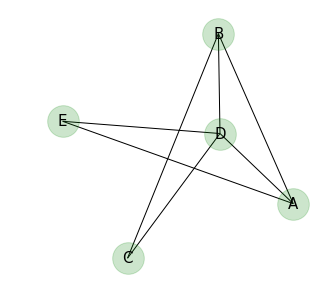

In [186]:
import math
import numpy as np
import time
import statistics
import networkx as nx
import matplotlib.pyplot as plt

window_size = 2
window_offset = math.ceil(window_size / 2)
window_offsets = [
    o for o in range(-window_offset, window_offset + 1) if o != 0
]


def remove_duplicates(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

dataset, stories = list(storiesMap.items())[0]
print(dataset)
empty_stories = [story for story in stories if story['body'] == '']
print('empty stories: ', len(empty_stories))

for story_idx, story in enumerate(stories):
    if story in empty_stories: 
        continue
    else:
        break
    
phrases = story['phrases']
stemmed_words = story['stemmed_words']
word_positions = story['word_positions']
word_levels = story['word_parsing_levels']

graph = nx.Graph()

graph.add_edge('A', 'B', weight=1)
graph.add_edge('B', 'C', weight=1)
graph.add_edge('B', 'D', weight=1)
graph.add_edge('C', 'B', weight=1)
graph.add_edge('D', 'C', weight=1)
graph.add_edge('D', 'E', weight=1)
graph.add_edge('D', 'A', weight=1)
graph.add_edge('E', 'A', weight=1)

# graph.add_edge('A', 'B', weight=1)
# graph.add_edge('E', 'A', weight=1)
# graph.add_edge('D', 'A', weight=1)
# graph.add_edge('D', 'E', weight=1)
# graph.add_edge('B', 'D', weight=1)
# graph.add_edge('B', 'F', weight=1)
# graph.add_edge('B', 'G', weight=1)
# graph.add_edge('E', 'H', weight=1)
# graph.add_edge('E', 'I', weight=1)
# graph.add_edge('D', 'J', weight=1)
# graph.add_edge('J', 'K', weight=1)

# graph.add_edge('A', 'B', weight=1)
# graph.add_edge('A', 'C', weight=1)
# graph.add_edge('B', 'C', weight=1)
# graph.add_edge('C', 'D', weight=2)

plt.figure(figsize=(5, 5))
plt.axis('off')
fig = plt.figure(1)
pos = nx.spring_layout(graph)
nx.draw_networkx_nodes(graph,pos, fixed=pos.keys(), node_color='g', alpha=0.2, node_size=1000)
nx.draw_networkx_edges(graph,pos)
nx.draw_networkx_labels(graph,pos, font_size=15)
plt.show()

In [184]:
import networkx as nx
from networkx.exception import NetworkXError
from networkx.utils import not_implemented_for

def pagerank(G, alpha=0.85, personalization=None,
             max_iter=100, tol=1.0e-6, nstart=None, weight='weight',
             dangling=None):
    assert(not G.is_directed())
    W = G.to_directed()
    N = W.number_of_nodes()
    x = dict.fromkeys(W, 1.0 / N)

    if personalization is None:
        # Assign uniform personalization vector if not given
        p = dict.fromkeys(W, 1.0 / N)
    else:
        missing = set(G) - set(personalization)
        if missing:
            raise NetworkXError('Personalization dictionary '
                                'must have a value for every node. '
                                'Missing nodes %s' % missing)
        s = float(sum(personalization.values()))
        p = dict((k, v / s) for k, v in personalization.items())

    # power iteration: make up to max_iter iterations
    for it in range(max_iter):
        xlast = x
        x = dict.fromkeys(xlast.keys(), 0)
        for n in x:
            for nbr in W[n]:
                x[n] += alpha * xlast[nbr] * (1 / len(W[nbr]))
            x[n] += (1.0 - alpha) * p[n]
        err = sum([abs(x[n] - xlast[n]) for n in x])
        if err < N*tol:
            print('coverged after: ', it)
            return x
    raise NetworkXError('pagerank: power iteration failed to converge '
                        'in %d iterations.' % max_iter)

for it in range(10):
    graph = nx.erdos_renyi_graph(1000, 0.1, directed=False)
#     plt.figure(figsize=(5, 5))
#     plt.axis('off')
#     fig = plt.figure(1)
#     pos = nx.spring_layout(graph)
#     nx.draw_networkx_nodes(graph,pos, fixed=pos.keys(), node_color='g', alpha=0.2, node_size=1000)
#     nx.draw_networkx_edges(graph,pos)
#     nx.draw_networkx_labels(graph,pos, font_size=15)
#     plt.show()

    ps1 = pagerank(graph).items()
    ps1 = sorted(ps1, key=lambda e : e[1], reverse=True)

    ps2 = nx.pagerank(graph).items()
    ps2 = sorted(ps2, key=lambda e : e[1], reverse=True)
        
    def print_(ps):
        for p, s in ps:
            print(p, ' ', s)
        print(' ')
        
    def compare(ps1, ps2):
        tol = 10**-5
        err = max([abs(p1[1] - p2[1]) for (p1, p2) in zip(ps1, ps2)])
        print(err)
        if err >= tol:
            for (p1, p2) in zip(ps1, ps2):
                e = abs(p1[1] - p2[1])
                if e >= tol:
                    print(p1[0], 'err: ', abs(p1[1] - p2[1]))
            return True
        return False
    compare(ps1, ps2)

coverged after:  2
1.0842021724855044e-18
coverged after:  2
1.0842021724855044e-18
coverged after:  2
8.673617379884035e-19
coverged after:  2
1.0842021724855044e-18
coverged after:  2
1.0842021724855044e-18
coverged after:  2
8.673617379884035e-19
coverged after:  2
8.673617379884035e-19
coverged after:  2
1.0842021724855044e-18
coverged after:  2
1.0842021724855044e-18
coverged after:  2
8.673617379884035e-19


In [193]:
graph = nx.Graph()
graph.add_edge('A', 'C', weight=1)
graph.add_edge('A', 'B', weight=2)
graph.add_edge('B', 'C', weight=1)

graph = graph.to_directed(graph)
for u in graph:
    print(u, graph[u])
print('')
graph = nx.stochastic_graph(graph)
for u in graph:
    print(u, graph[u])

A {'C': {'weight': 1}, 'B': {'weight': 2}}
C {'A': {'weight': 1}, 'B': {'weight': 1}}
B {'A': {'weight': 2}, 'C': {'weight': 1}}

A {'C': {'weight': 0.3333333333333333}, 'B': {'weight': 0.6666666666666666}}
C {'A': {'weight': 0.5}, 'B': {'weight': 0.5}}
B {'A': {'weight': 0.6666666666666666}, 'C': {'weight': 0.3333333333333333}}
